In [32]:
import re
import random
import pandas as pd
import hashlib

In [33]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)



cards_to_age['head'] = cards_to_age['head'].str.strip()

# remove headers I don't want anymore
undesired_headers = ['CCH Axcess']
cards_to_age = cards_to_age.loc[~cards_to_age['head'].isin(undesired_headers), :].copy()

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [34]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Node.JS and React,482.403847,15.561414,22.189921,31
"Mexican Gothic, Moreno-Garcia",850.956878,30.391317,58.240610,28
Azure Functions Core Tools,602.339359,35.431727,49.145562,17
C# Basics,46.656566,46.656566,46.656566,1
Node.js and Vite,2169.128928,52.905584,83.927025,41
Django,2148.007144,53.700179,75.452014,40
Python,4851.218601,62.195110,179.831154,78
Azure Files Documentation,4014.444052,66.907401,158.455567,60
Active Directory and Azure Files,2709.111592,73.219232,113.169072,37
CCH Tax Forms Project,1581.671387,75.317685,149.228033,21


# Histogram

sum of ages: ~52946.49


<Axes: >

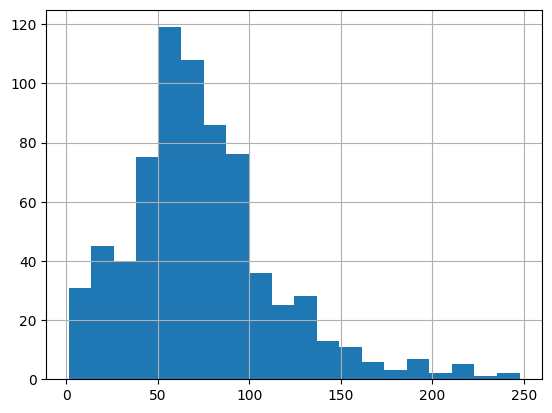

In [35]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~52946.49


<Axes: >

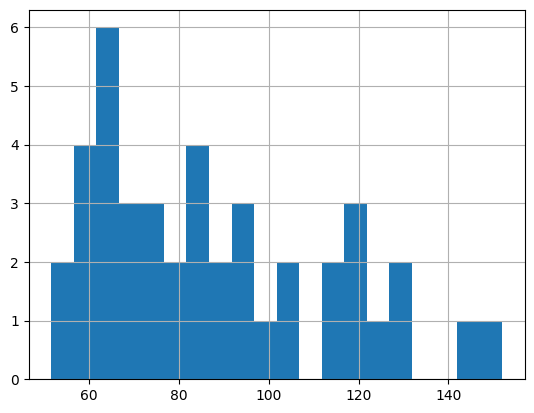

In [36]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Terraform Codebox']['age'].hist(bins=20)

# Completely Random Shuffle

In [37]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [38]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [ ]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


Cards found: 719
Total card age: 52946.49


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
70,Microsoft Purview,Define what each label can do. Configure the p...,2314da7a2bfdaa36bc1e3f2e5633935f,-216.992343,87.299056,216.992343,-5237.943335,0.060443,60,0,0
320,Microsoft Purview,Data discovery is about ensuring users can fin...,ec32321cb3d7e61570db862babcb49d5,-194.004833,87.299056,216.992343,-5237.943335,0.060443,60,3,0
72,Microsoft Purview,Sensitivity labels provide users and admins wi...,8d16954779c548480a8a2b400a5b9f14,-165.073412,87.299056,216.992343,-5237.943335,0.060443,60,6,0
322,Microsoft Purview,"In Microsoft Purview, you implement data loss ...",b887e0d3666dabff53051bf67aee3c9d,-150.281659,87.299056,216.992343,-5237.943335,0.060443,60,9,0
74,Microsoft Purview,If your organization has implemented administr...,23227cad18b6ff86c0a03d28c42b4b56,-145.074432,87.299056,216.992343,-5237.943335,0.060443,60,12,0
75,Microsoft Purview,A governance domain can house many data produc...,e868534b82477ddd695e45e05d74de43,-111.306461,87.299056,216.992343,-5237.943335,0.060443,60,15,0
76,Microsoft Purview,"In a data loss prevention policy, you:\n\n ...",246387213749acfff12ac579310dabb8,-108.277600,87.299056,216.992343,-5237.943335,0.060443,60,18,0
565,Microsoft Purview,Governance domains: Governance domains are a n...,02284fdac91491e026bb1052af5819cb,-97.383201,87.299056,216.992343,-5237.943335,0.060443,60,21,0
78,Microsoft Purview,Create the labels. Create and name your sensit...,dbd666bd61e9c0c27471e5d0372d20da,-94.668277,87.299056,216.992343,-5237.943335,0.060443,60,24,0
79,Microsoft Purview,Administrative units in Microsoft Entra ID ena...,7f922e465c70a4e1cf78e89561b3efbc,-87.427071,87.299056,216.992343,-5237.943335,0.060443,60,27,0


## Age Mean

In [ ]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

## Age Max

In [41]:
# n = 5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [42]:
# n=5
# # existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [43]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [44]:
existing_cards.head(10)['age'].sum()

np.float64(-1370.4892869512573)

In [45]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
32,Power BI,Why can’t you reference a newly added column a...,a550364578e3469f2990bdec6904efc0,-247.714082,98.186570,247.714082,-3141.970229,0.519377,32,0,0
6,PnP PowerShell,Environment Variables\nVariables that are set ...,e888c7c4c00e3b122457c3d900fd4e77,-243.231547,99.662962,243.231547,-2690.899976,0.413606,27,0,0
15,JavaScript Concepts,Generate distinct arrays with fill() + map()\n...,1c477652c74da3a626b132108ec4229f,-225.982964,99.057841,225.982964,-4952.892046,0.254696,50,0,0
256,PnP PowerShell,REST API Endpoints\nSpecific URLs used to acce...,b12f5012328f32a6c689485970705806,-221.643334,99.662962,243.231547,-2690.899976,0.413606,27,1,1
242,Azure Compute Gallery,Subscription Quotas – Limits on the number of ...,ccb8c05118173479053ff181ddffe698,-219.322513,102.181249,219.322513,-1226.174989,0.519293,12,0,0
70,Microsoft Purview,Define what each label can do. Configure the p...,2314da7a2bfdaa36bc1e3f2e5633935f,-216.992343,87.299056,216.992343,-5237.943335,0.060443,60,0,0
265,JavaScript Concepts,Express.js: A minimalist web framework for Nod...,425c10164d26897fdad3f9d7c2c6f523,-215.120986,99.057841,225.982964,-4952.892046,0.254696,50,1,1
319,Microsoft Purview,"When you create your DLP policies, you should ...",8ec1edc0f421bb7de2884cb3c7089b3e,-214.225836,87.299056,216.992343,-5237.943335,0.060443,60,1,1
248,Vocab,"Something Rotten, Fforde\nSalver\nnoun | SAL-v...",c8d10134bc737eb530dfa3f6d3e44e00,-208.167495,93.874120,208.167495,-2065.230643,0.898968,22,0,0
508,JavaScript Concepts,Many operators coerce the operands into number...,c7910dc971abc5da390f0193c2ffbdc8,-204.252355,99.057841,225.982964,-4952.892046,0.254696,50,2,2


In [46]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 73.639'